In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn import Module

from context import *
from LocalLearning import ModelFactory, HiddenLayerModel, KHModel, SHLP, FKHL3
from LocalLearning.Data import BaselineAccurateTestData, LpUnitCIFAR10, DeviceDataLoader, GaussianData
from LocalLearning.Attacks import AdversarialAttack, WhiteGaussianPerturbation, FGSM, PGD, AttackTest
from LocalLearning.Experiments import PerturbationExperiment, RandomPerturbationExperiment, FGSMExperiment, PGDExperiment
from LocalLearning.Statistics import cov_spectrum
from scipy import stats

from pathlib import Path
from collections import OrderedDict
import pickle as pkl

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use(['seaborn-paper', "./ICLRFullTextwidthFigureStyle.mplstyle"])

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# path variables
# model directory
directory = Path("../data/ICLR/models")
figure_directory = Path("../data/ICLR/figures")

# model filenames
khlayer_cifar10_pruned_name = Path("fkhl3_cifar10_pruned_thr.pty")
khlayer_cifar10_name = Path("fkhl3_cifar10.pty")

#fn_list = [khmodel_name, shlp_name, shlp_l2_name, shlp_jreg_name, shlp_specreg_name]
#fn_list = [shlp_name, khmodel_name]

# hyper parameters
BATCH_SIZE = 1000

In [4]:
theFactory = ModelFactory()

In [5]:
state_dict = torch.load(directory / khlayer_cifar10_name)
khlayer = theFactory.build_from_state(state_dict)
khlayer.eval()
khlayer.to(device)

state_dict_pruned = torch.load(directory / khlayer_cifar10_pruned_name)
khlayer_pruned = theFactory.build_from_state(state_dict_pruned)
khlayer_pruned.eval()
khlayer_pruned.to(device)

FKHL3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [6]:
def NormalizeMinMax(x: torch.Tensor) -> torch.Tensor:
    mi = torch.amin(x)
    ma = torch.amax(x)
    if torch.abs(ma - mi) < 1e-8:
        return torch.zeros(x.shape)
    return (x - mi) / (ma - mi)

In [7]:
def plot_model_weights(ax, model: FKHL3, Kx=30, Ky=20, fig_width_in=12.9, fig_height_in=10.0, shuffle=False, x0=0, y0=0):
    with torch.no_grad():
        # extract weight matrix from model and convert to numpy array
        W = model.W.detach().cpu().clone()
        W = W.T
        
        if shuffle:  # randomly choose Kx*Ky hidden entries
            x0 = y0 = 0
            W = W[np.random.choice(W.shape[0], Kx*Ky, replace=False)]
    
    yy=y0 + Kx*x0
    HM=torch.zeros((32*Ky, 32*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[(y)*32:(y + 1)*32,x*32:(x + 1)*32, :]=NormalizeMinMax(W[yy].reshape(32, 32, 3))
            yy += 1
    
    #nc=torch.max(torch.abs(HM))
    im=ax.imshow(HM.detach().cpu().numpy(),cmap='bwr')#,vmin=-nc,vmax=nc)
    #fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    ax.axis('off')
    
    return ax

In [9]:
cifar10Test = LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=khlayer.pSet["p"],
)

gauss_noise_params = {
    "mu": 0.0, # standard normal process
    "sigma": 1.0,
    "img_width_px": 32, # cifar10 parameters
    "img_height_px": 32,
    "img_ch_num": 3, 
}
GaussianNoisedSet = GaussianData(
    gauss_noise_params,
    train=False,
)

TestLoader = DeviceDataLoader(
        cifar10Test,
        device=device,
        batch_size=BATCH_SIZE,
        num_workers=4,
        shuffle=False,
    )
GaussLoader = DataLoader(
        GaussianNoisedSet,
        batch_size=BATCH_SIZE,
        num_workers=4,
        shuffle=False,
    )

Files already downloaded and verified


In [10]:
l_n_cifar10 = cov_spectrum(TestLoader, khlayer, khlayer.pSet["hidden_size"])
l_n_cifar10_pruned = cov_spectrum(TestLoader, khlayer_pruned, khlayer_pruned.pSet["hidden_size"])
l_n_gauss = cov_spectrum(GaussLoader, khlayer, khlayer.pSet["hidden_size"])
l_n_gauss_pruned = cov_spectrum(GaussLoader, khlayer_pruned, khlayer_pruned.pSet["hidden_size"])

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

In [11]:
def plot_weight_variance_histogram(ax, model: FKHL3, 
                                   var_range=(1e-9, 3e-3), no_bins=50, clr='b', alpha=1.0,
                                  ):
    with torch.no_grad():
        W = model.W.detach().cpu().clone().T
        vars_W = torch.var(W, dim=1, keepdim=True)
    counts, bins = np.histogram(vars_W.numpy(), bins=no_bins, range=var_range, density=False)
    ax.hist(bins[:-1], bins, weights=counts, color=clr, alpha=alpha)
    return ax

/tmp/ipykernel_119328/101504656.py:71: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(figure_directory / Path("ICLR-PruningWeightsSpectra.pdf"))
/tmp/ipykernel_119328/101504656.py:72: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(Path("ICLR-PruningWeightsSpectra.pdf"))
/home/konstantin/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


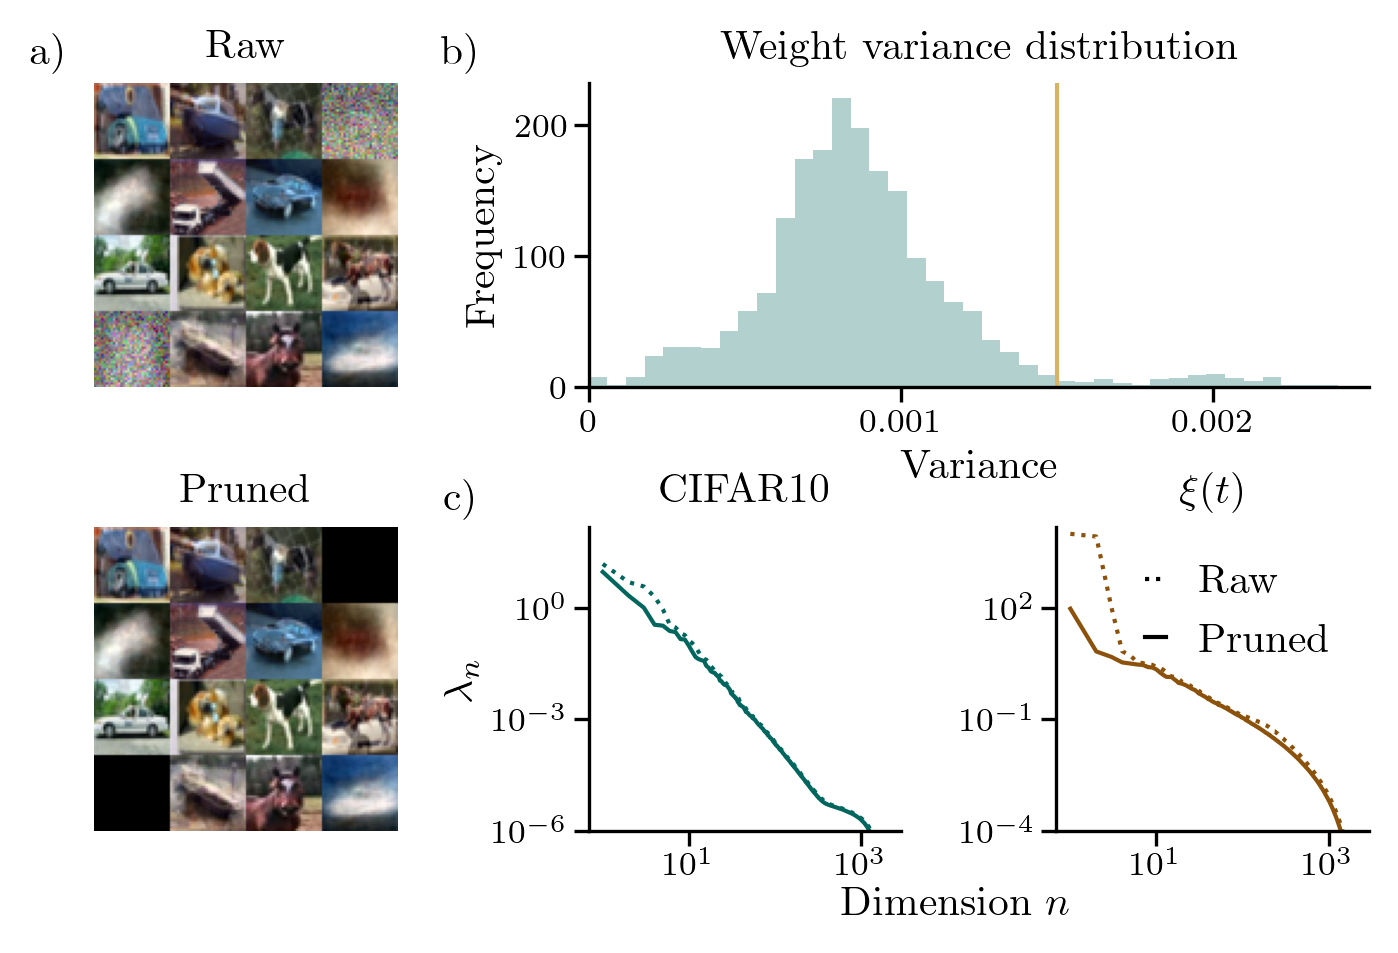

In [19]:
clr_map = {
    "cifar": '#01665e',
    "gauss": '#8c510a',
}

fig = plt.figure(constrained_layout=True)
#fig.tight_layout()
fig.set_figheight(3.3)
width_ratios = [0.5, 0.1, 0.5, 0.05, 0.5]
height_ratios = [1.0, 0.05, 1.0]
gs = mpl.gridspec.GridSpec(3, 5, width_ratios=width_ratios, height_ratios=height_ratios)

# plot the image collections
img_ax = fig.add_subplot(gs[0, 0])
img_ax = plot_model_weights(img_ax, khlayer, Kx=4, Ky=4, x0=190, y0=1)
img_ax.set_title(r"Raw")

img_ax_pruned = fig.add_subplot(gs[2, 0])
img_ax_pruned = plot_model_weights(img_ax_pruned, khlayer_pruned, Kx=4, Ky=4, x0=190, y0=1)
img_ax_pruned.set_title(r"Pruned")

hist_ax = fig.add_subplot(gs[0, 2:])
hist_ax = plot_weight_variance_histogram(hist_ax, khlayer, clr=clr_map["cifar"], alpha=0.3)
hist_ax.axvline(x = 0.0015, color='#d8b365')
hist_ax.set_xlim((0.0, 2.5e-3))
hist_ax.set_xticks([0.0, 1e-3, 2e-3], labels=['0', '0.001', '0.002'])
hist_ax.set_xlabel(r"Variance")
hist_ax.set_ylabel(r"Frequency")
hist_ax.set_title(r"Weight variance distribution")

spec_ax_1 = fig.add_subplot(gs[2, 2])
n = np.arange(1, len(l_n_cifar10) + 1)
l_n_c10 = l_n_cifar10.detach().cpu().numpy().copy()
#l_n_c10 /= l_n_c10[0]
spec_ax_1.loglog(n, l_n_c10, linestyle=":", color=clr_map["cifar"])
l_n_c10_pr = l_n_cifar10_pruned.detach().cpu().numpy().copy()
#l_n_c10_pr /= l_n_c10_pr[0]
spec_ax_1.loglog(n, l_n_c10_pr, linestyle="-", color=clr_map["cifar"])
spec_ax_1.set_ylim((1e-6, 1.5e2))
spec_ax_1.set_ylabel(r"$\lambda_{n}$")
spec_ax_1.set_title(r"CIFAR10")

spec_ax_2 = fig.add_subplot(gs[2, 4])
n = np.arange(1, len(l_n_gauss) + 1)
l_n_g = l_n_gauss.detach().cpu().numpy().copy()
#l_n_g /= l_n_g.sum()
spec_ax_2.loglog(n, l_n_g, linestyle=":", color=clr_map["gauss"])
l_n_g_pr = l_n_gauss_pruned.detach().cpu().numpy().copy()
#l_n_g_pr /= l_n_g.sum()
spec_ax_2.loglog(n, l_n_g_pr, linestyle="-", color=clr_map["gauss"])
spec_ax_2.set_ylim((1e-4, 1.5e4))
spec_ax_2.set_title(r"$\xi(t)$")

# legend
lines = [
    mpl.lines.Line2D([0], [0], color="#000000", linestyle=":"),
    mpl.lines.Line2D([0], [0], color="#000000", linestyle="-"),
]
spec_ax_2.legend(
    lines, 
    [r"Raw", r"Pruned"], 
    loc='upper right',
    handlelength=0.5,
)

fig.text(0.65, 0.04, r"Dimension $n$", ha='center')
fig.text(0.1, 0.9, r"a)", ha='center')
fig.text(0.35, 0.9, r"b)", ha='center')
fig.text(0.35, 0.45, r"c)", ha='center')

fig.savefig(figure_directory / Path("ICLR-PruningWeightsSpectra.pdf"))
fig.savefig(Path("ICLR-PruningWeightsSpectra.pdf"))